In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

In [2]:
data_dir = '../data/Screwdriving Model Experiments'
observation_file = 'observation_data.csv'
sensor_file = 'sensor_data.csv'
merged_file = 'merged_data.csv'
subdirs = os.listdir(data_dir)
files = list(map(lambda sd: os.path.join(data_dir, sd, observation_file), subdirs))
# files

In [3]:
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# df.head()

In [4]:
df.isna().sum()

time     0
X       66
Y       66
Z       66
dtype: int64

In [5]:
# df.describe()

4.57769


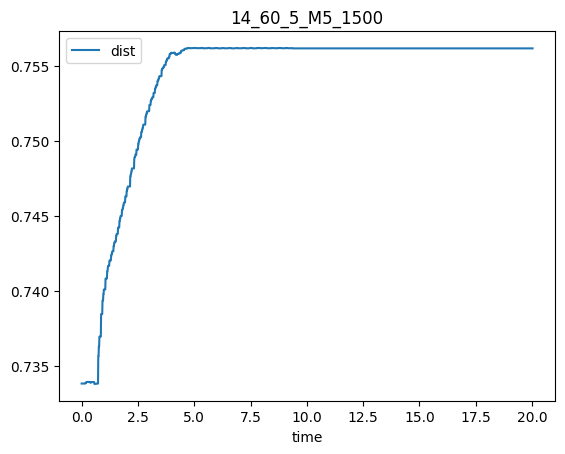

2.903985


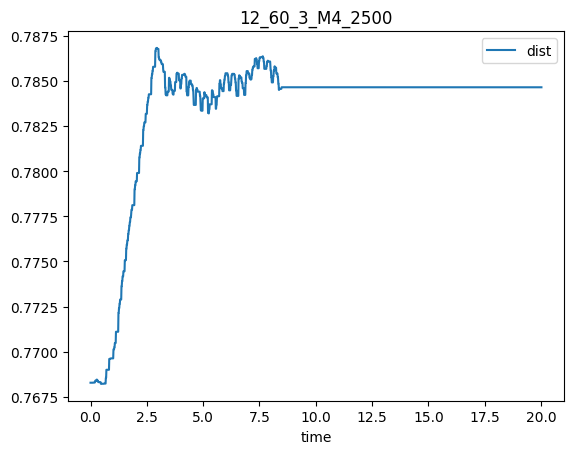

3.322185


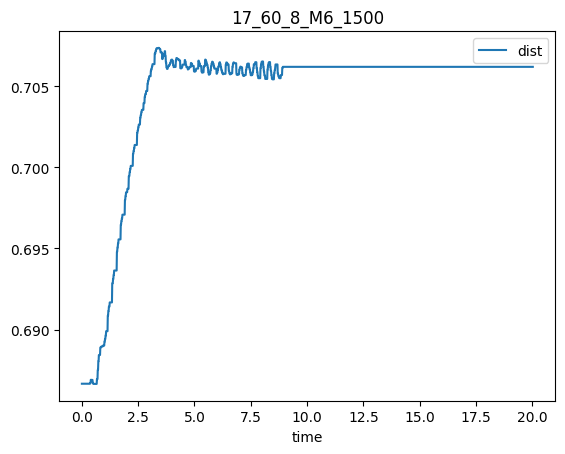

8.511759


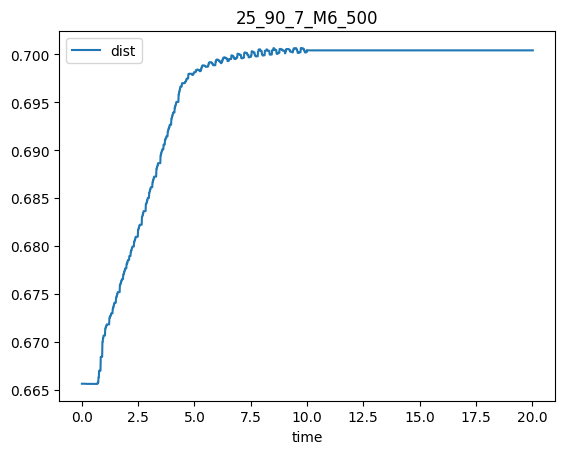

0.0


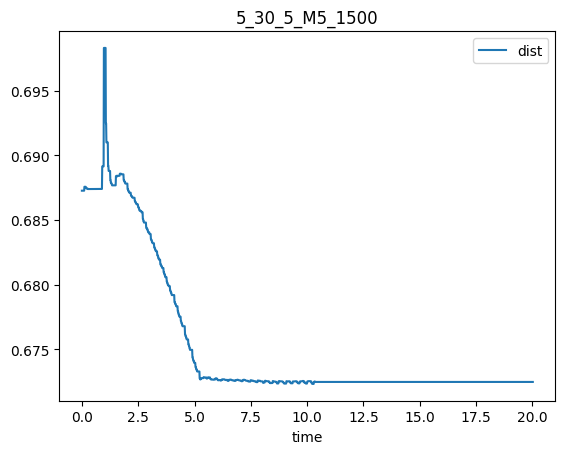

3.833257


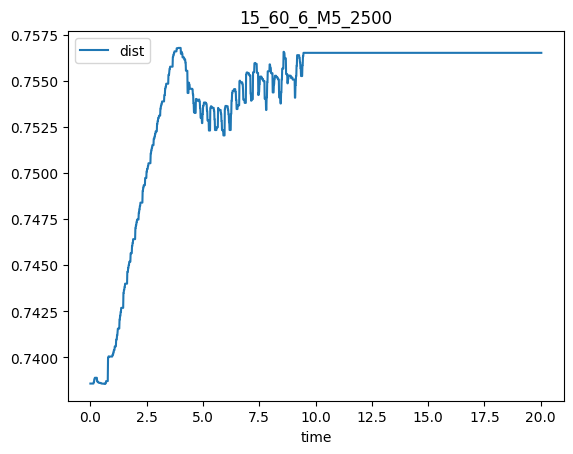

5.31185


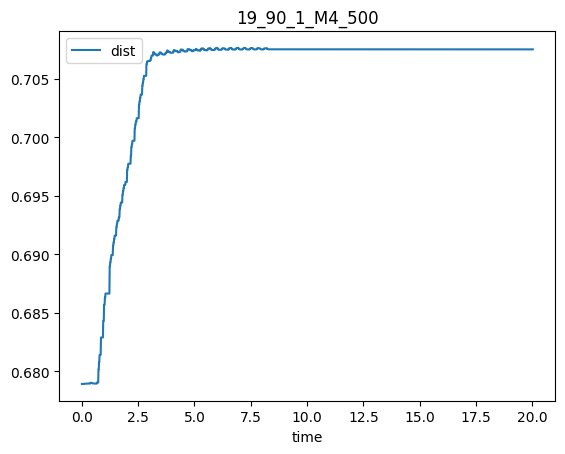

0.0


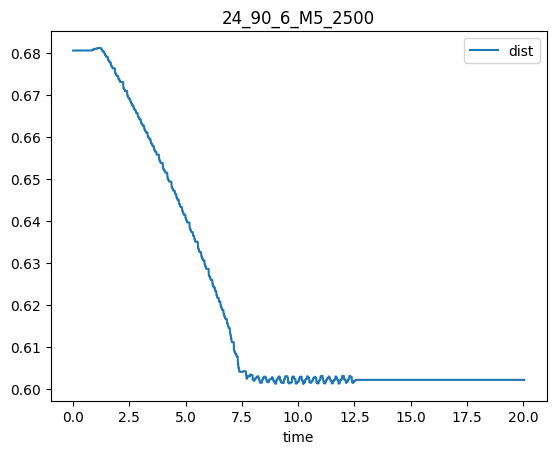

0.0


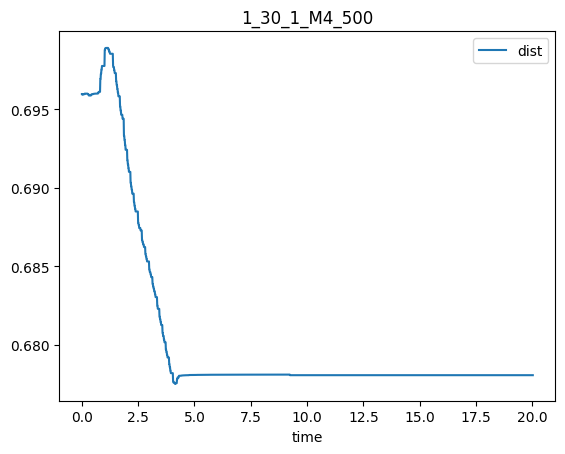

3.277385


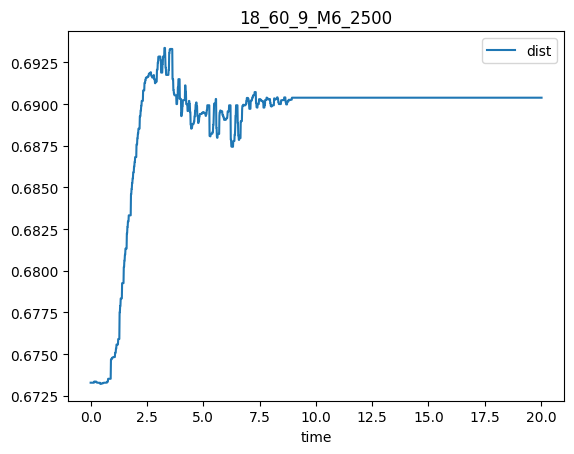

0.0


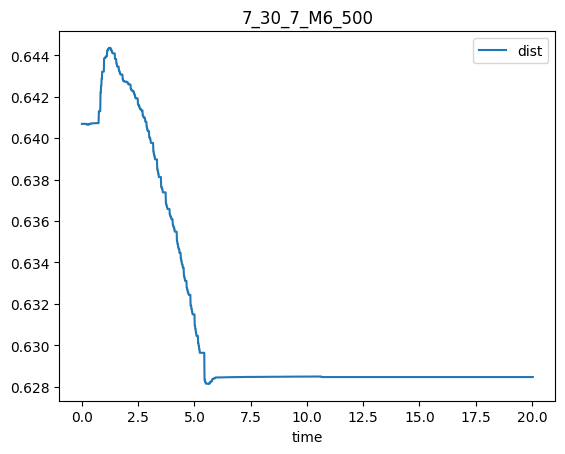

4.111444


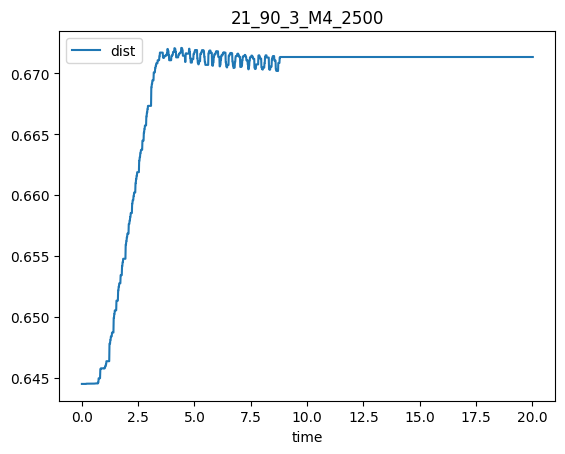

3.083161


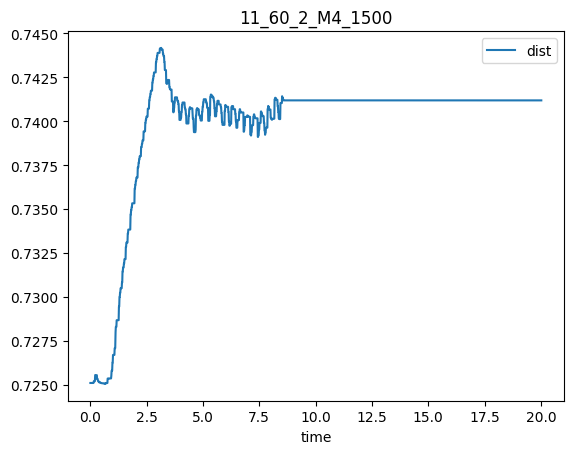

0.0


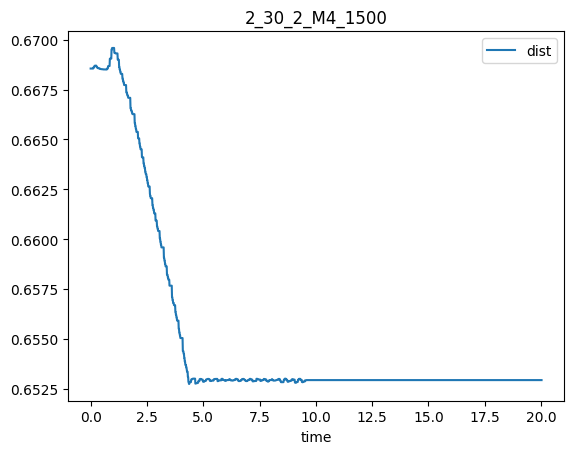

3.332682


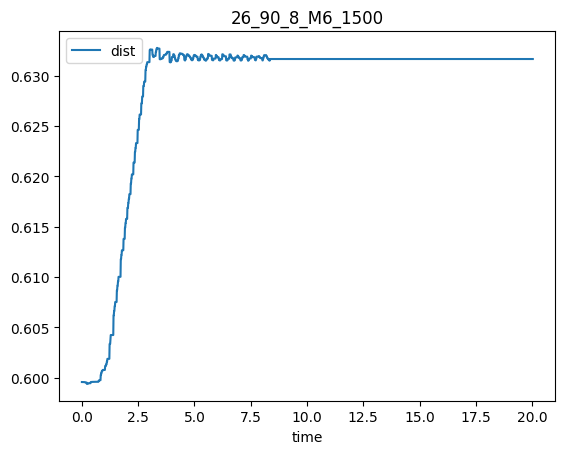

0.0


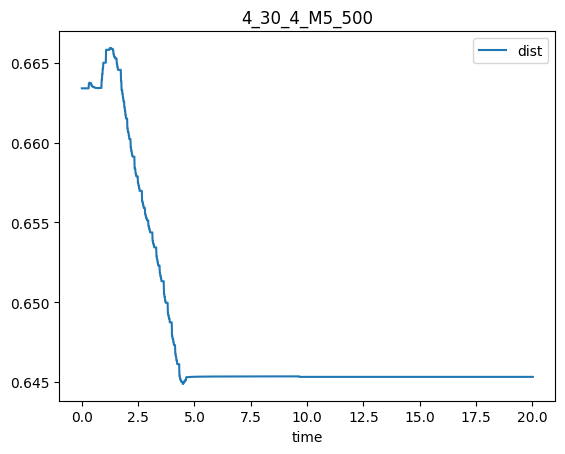

0.0


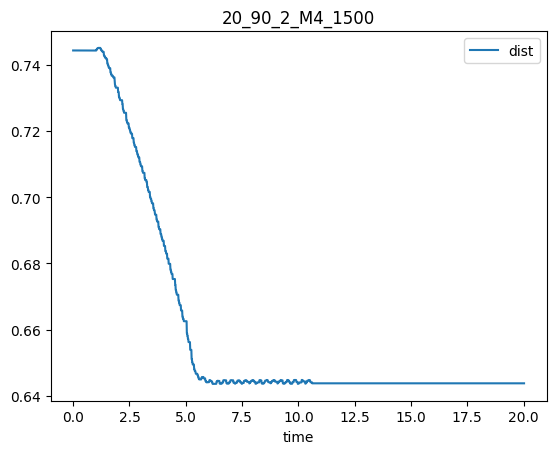

4.278586


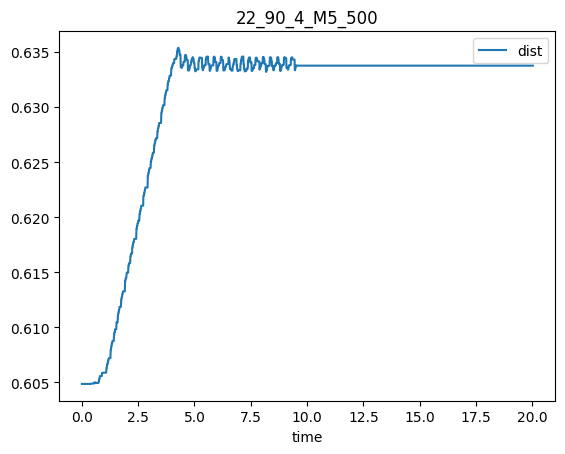

0.0


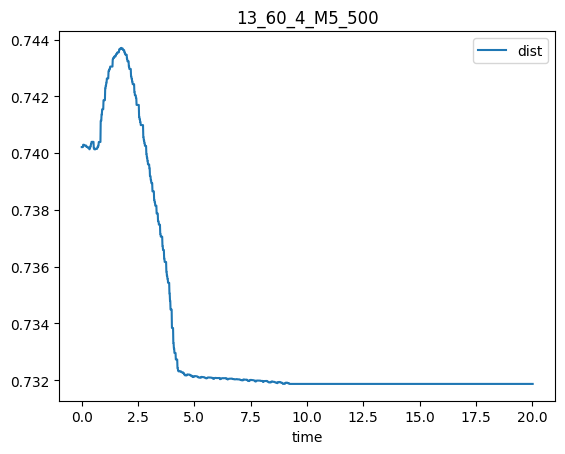

3.723399


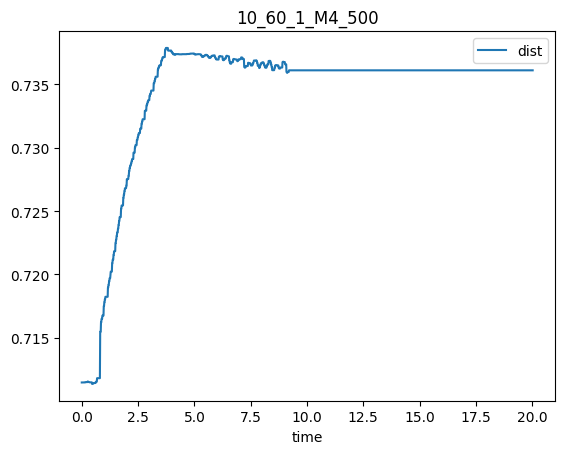

3.746236


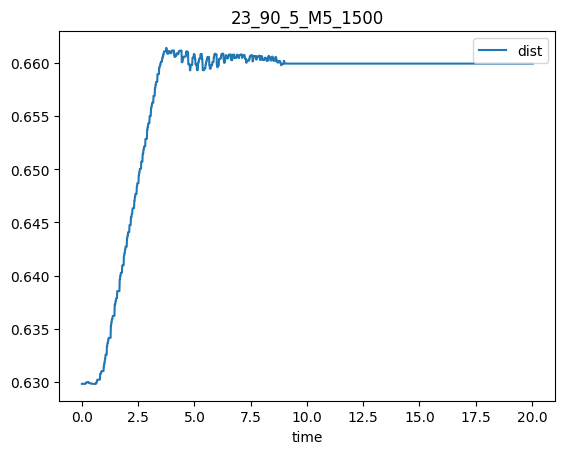

0.0


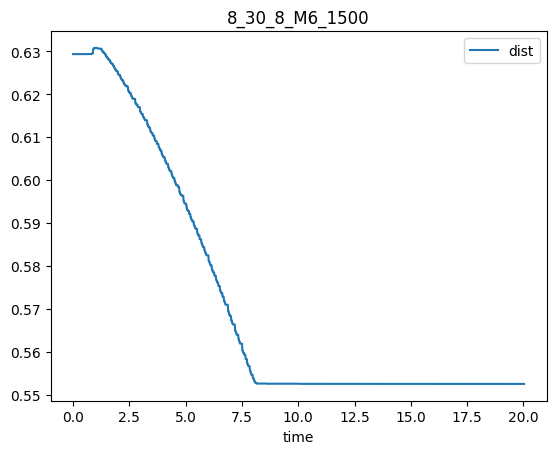

0.0


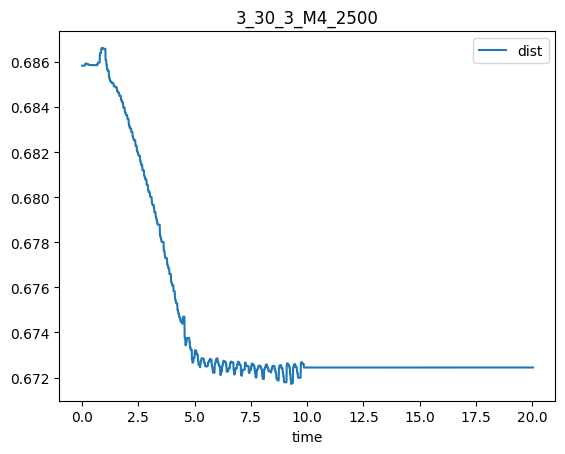

0.0


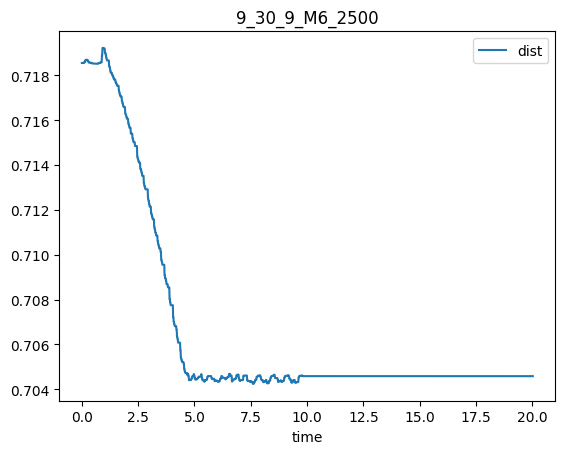

3.45216


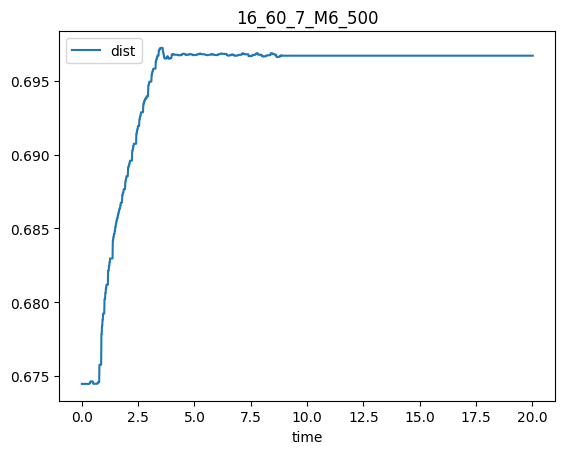

3.756909


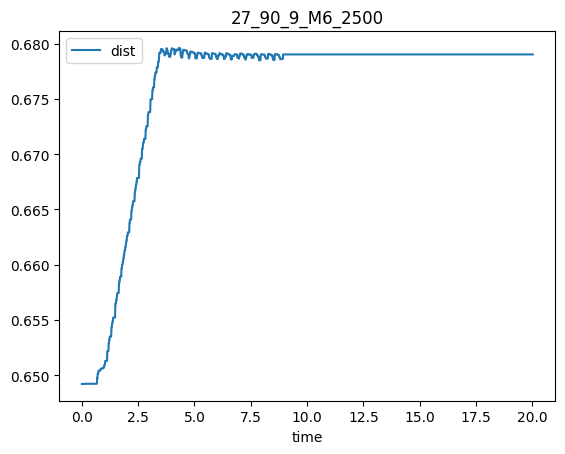

0.0


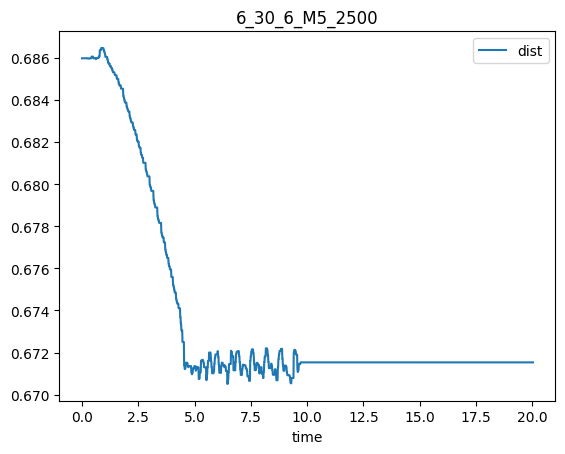

In [6]:
for subdir in subdirs:

    observation_path = os.path.join(data_dir, subdir, observation_file)
    sensor_path = os.path.join(data_dir, subdir, sensor_file)
    
    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    obs_df['ref_time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    sen_df['time'] = pd.to_datetime(sen_df['time'])
    obs_df['ref_time'] = (obs_df['ref_time'] - obs_df['ref_time'].min()).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2 + sen_df['Z'] ** 2)

    is_increasing = sen_df['dist'].iloc[-1] - sen_df['dist'].iloc[0] > 0
    tp_idx = sen_df[sen_df['dist'] >= 0.9999 * sen_df['dist'].max()].index.min() if is_increasing else \
        sen_df[sen_df['dist'] >= 1.0001 * sen_df['dist'].min()].index.min()

    print(sen_df.iloc[tp_idx]['time'])

    sen_df.plot(x='time', y=['dist'], kind='line')
    plt.title(label=subdir)
    plt.show()

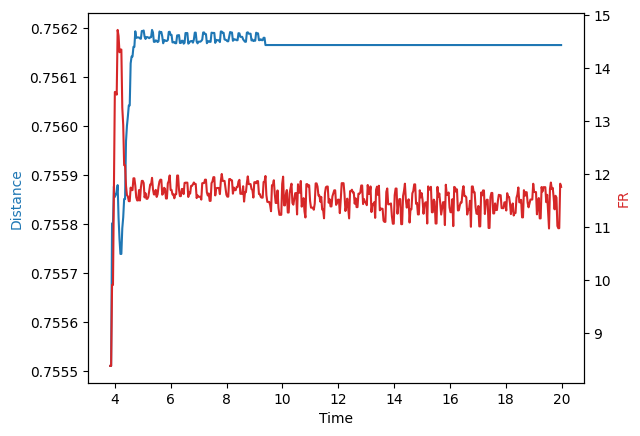

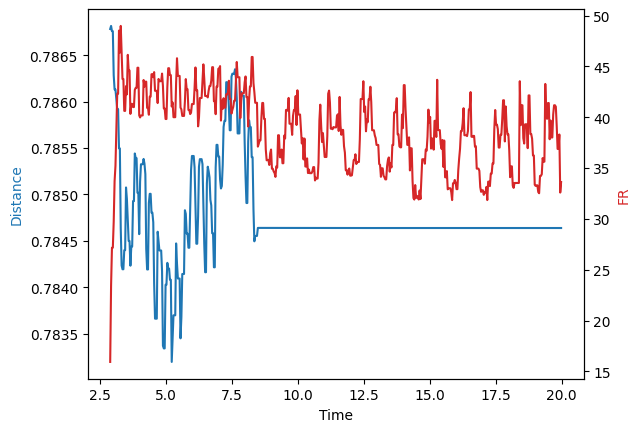

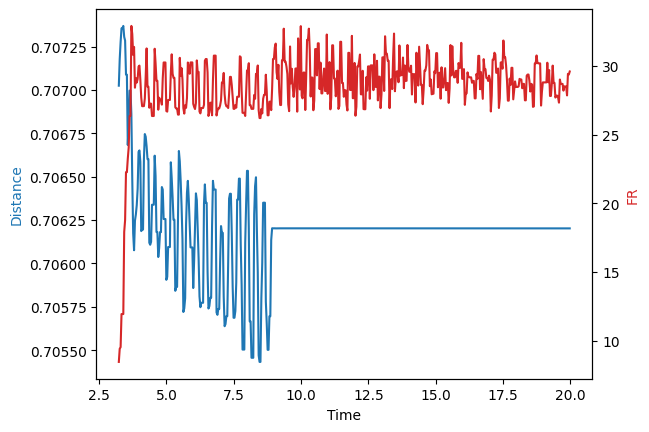

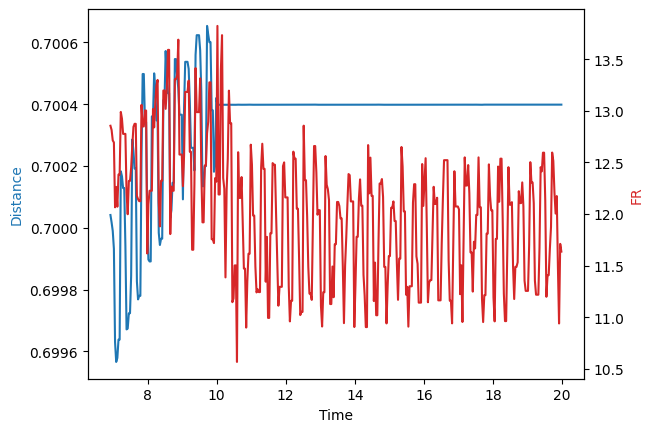

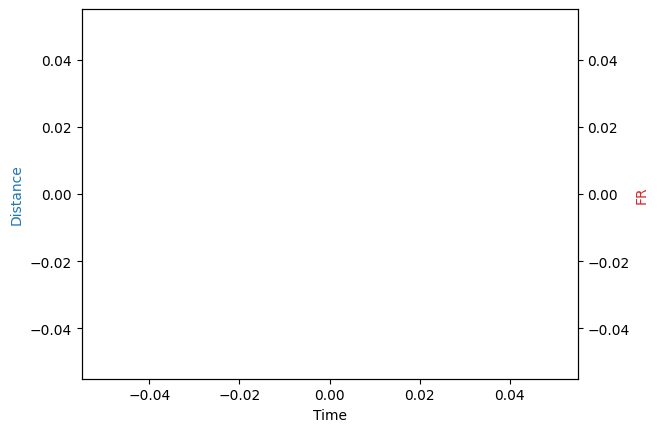

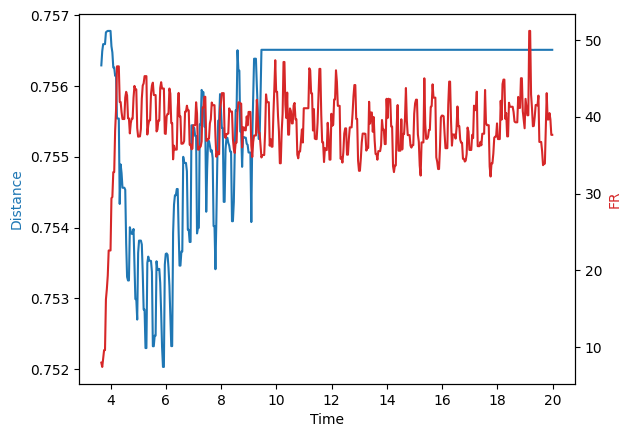

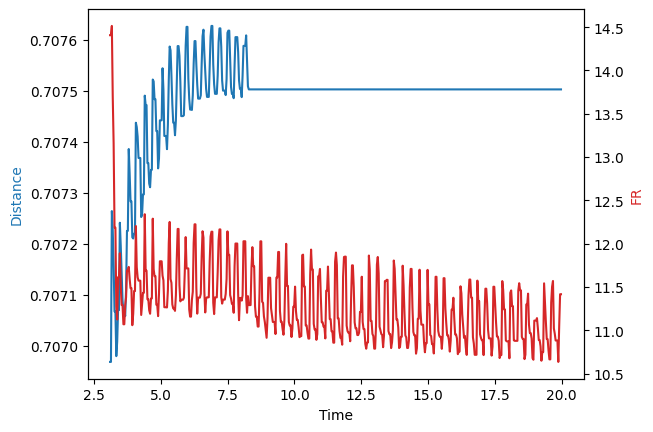

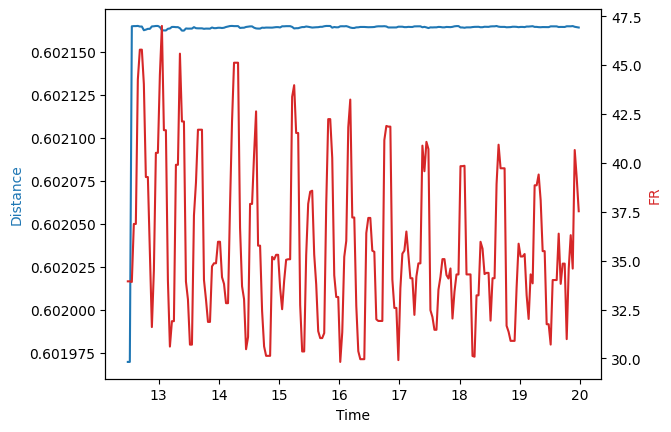

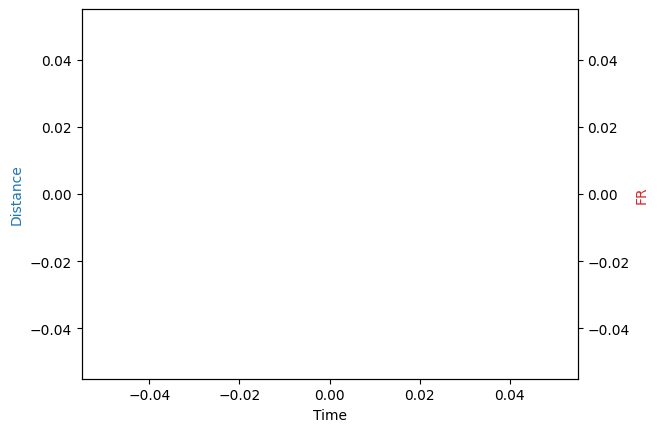

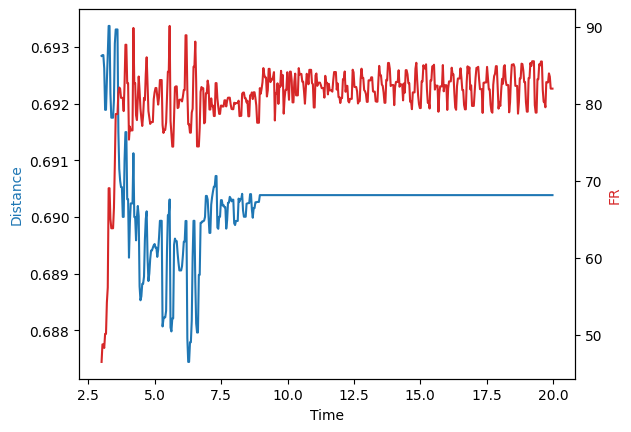

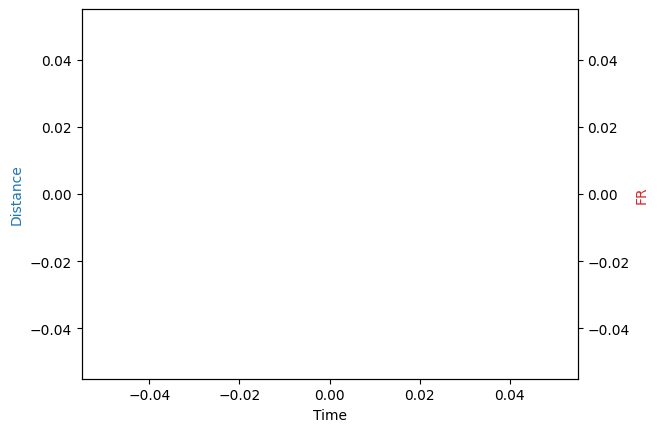

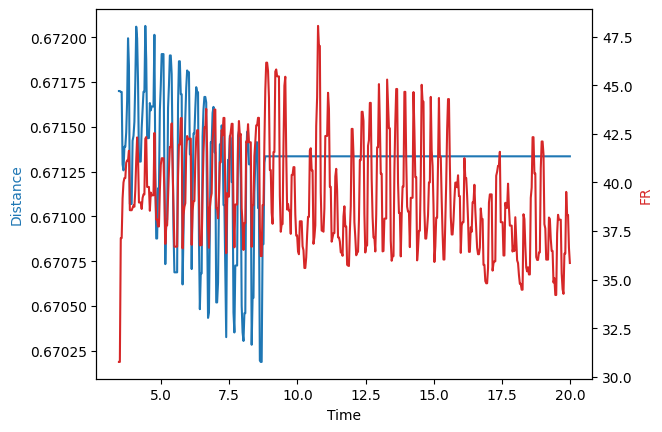

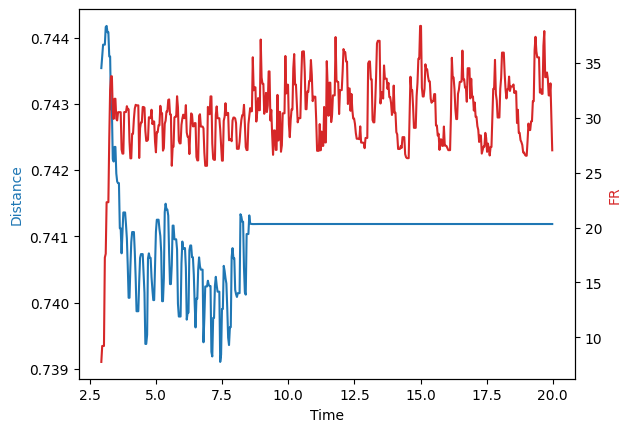

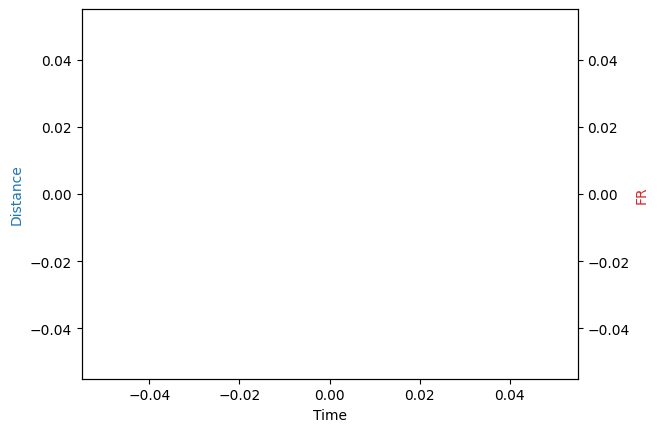

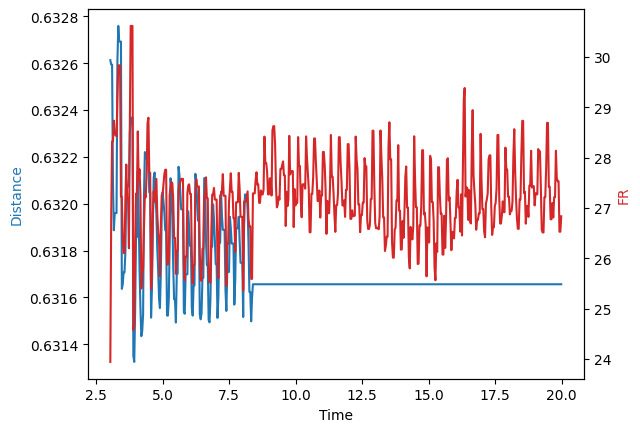

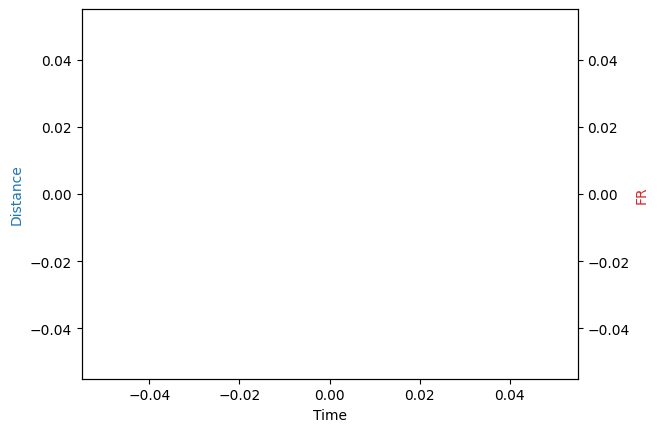

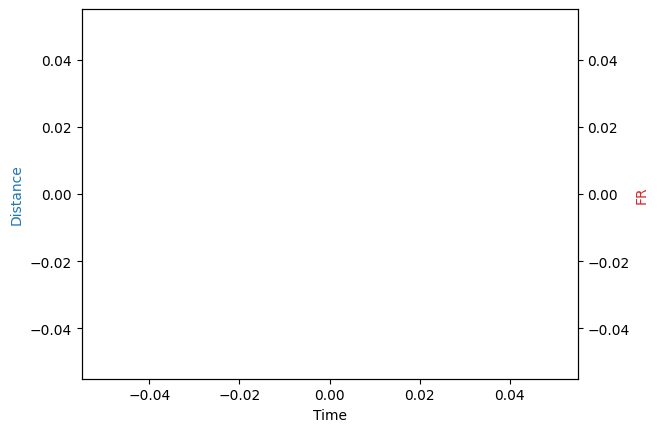

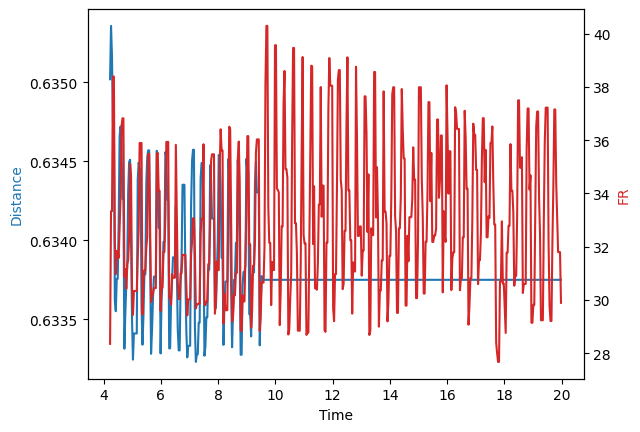

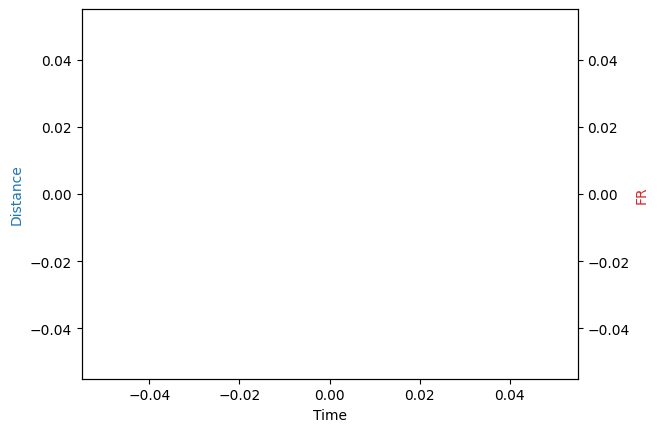

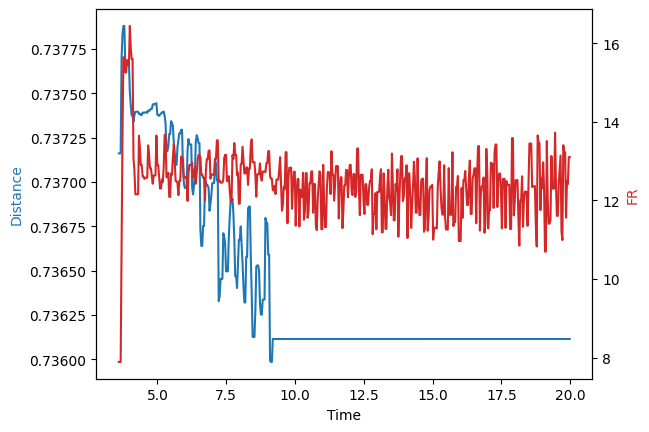

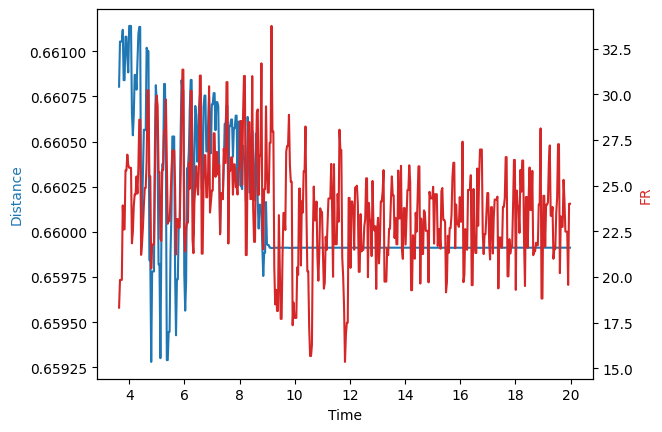

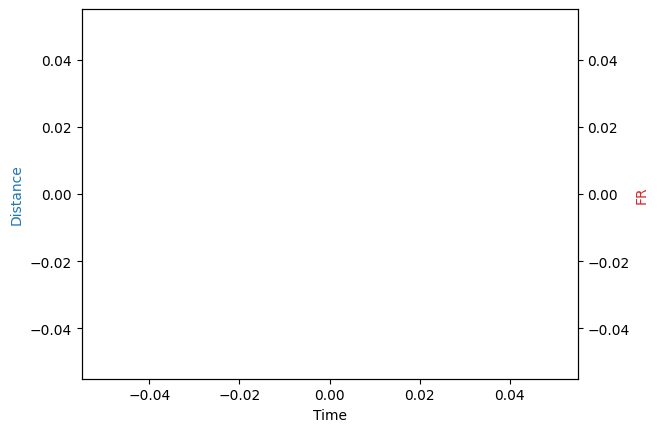

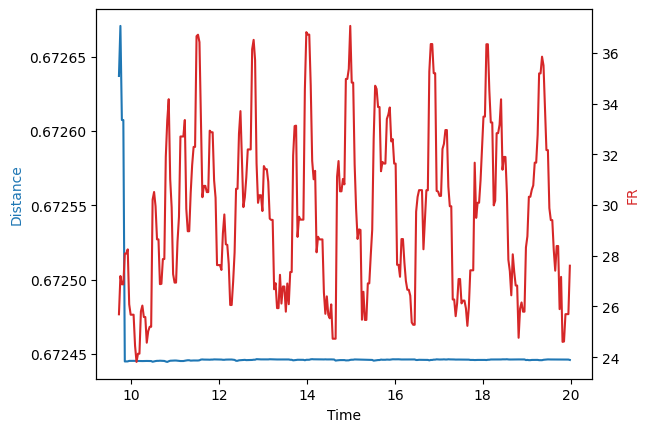

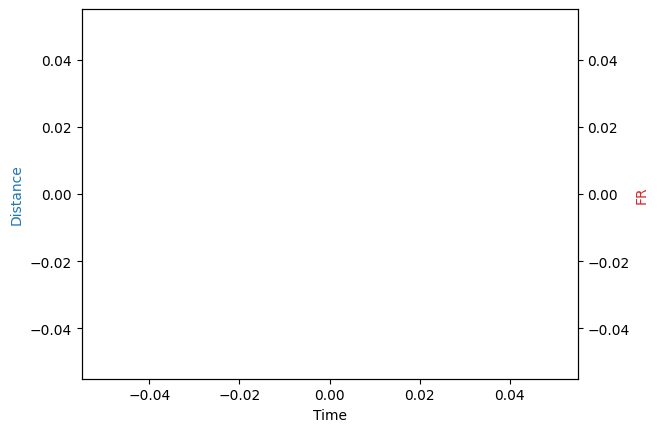

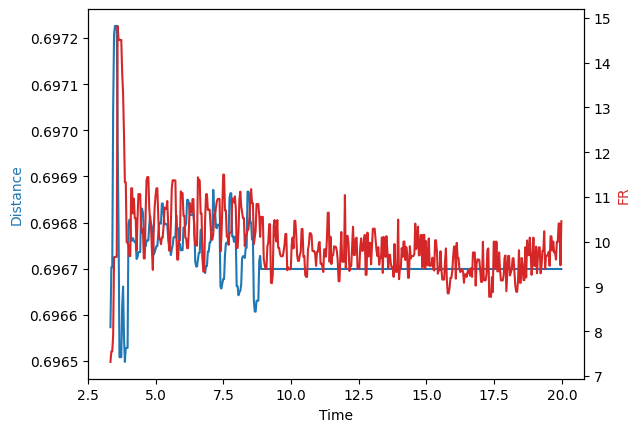

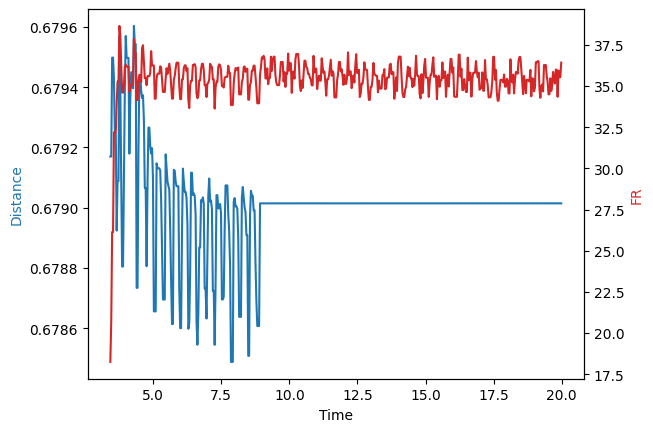

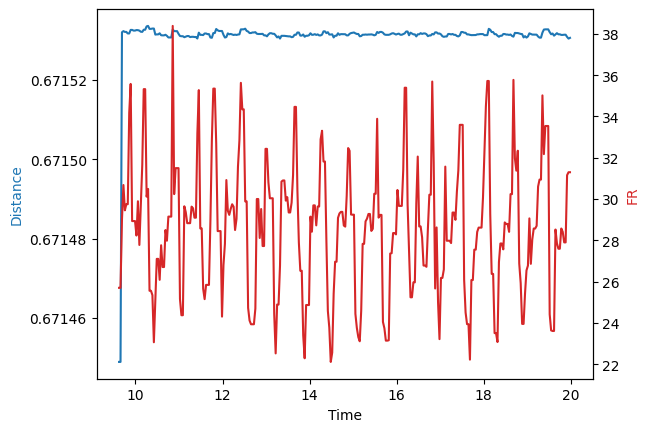

In [7]:
offset = -0.010  # seconds (sensor is this much time ahead of the camera, minus means behind; manually verified with the image timestamp)

for subdir in subdirs:
    observation_path = os.path.join(data_dir, subdir, observation_file)
    sensor_path = os.path.join(data_dir, subdir, sensor_file)
    
    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    
    obs_df['time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    obs_df['time'] = (obs_df['time'] - obs_df['time'].min()).dt.total_seconds()
    
    sen_df['time'] = pd.to_datetime(sen_df['time'])    
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] + offset)

    observation_path_out = os.path.join(data_dir, subdir, 'aligned_{}'.format(observation_file))
    sensor_path_out = os.path.join(data_dir, subdir, 'aligned_{}'.format(sensor_file))
    obs_df.to_csv(observation_path_out, index=False)
    sen_df.to_csv(sensor_path_out, index=False)

    sen_df['fr'] = np.sqrt(sen_df['fx'] ** 2 + sen_df['fy'] ** 2 + sen_df['fz'] ** 2)
    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2 + sen_df['Z'] ** 2)
    is_increasing = sen_df['dist'].iloc[-100:-1].mean() - sen_df['dist'].iloc[0:100].mean() > 0
    tp_idx = sen_df[sen_df['dist'] >= sen_df['dist'].max() * 0.999].index.min() if is_increasing else \
        sen_df[sen_df['dist'] <= sen_df['dist'].min() * 1.001].index.max()
    trim_time = sen_df['time'][tp_idx]
    
    tolerance = np.abs(offset)
    merged_df = pd.merge_asof(obs_df, sen_df.drop(columns=['X', 'Y', 'Z']), on='time', tolerance=tolerance, direction='nearest')
    merged_df = merged_df[merged_df['time'] >= trim_time]
    merged_df.reset_index(drop=True, inplace=True)
    merged_path_out = os.path.join(data_dir, subdir, merged_file)

    fig, ax1 = plt.subplots()
    ax1.plot(merged_df['time'], merged_df['dist'], color='tab:blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Distance', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(merged_df['time'], merged_df['fr'], color='tab:red')
    ax2.set_ylabel('FR', color='tab:red')
    plt.show()
    for column in ['X', 'Y', 'Z']:
        merged_df[column] = merged_df[column].ewm(alpha=0.2).mean()

    fig = go.Figure(data=[go.Scatter3d(
        x=merged_df['X'],
        y=merged_df['Y'],
        z=merged_df['Z'],
        mode='markers',
        marker=dict(
            size=1,
            opacity=0.8
        ),
    )])
    fig.update_layout(width=800, height=400)
    fig.show()

    merged_df.to_csv(merged_path_out, index=False)
